# Config

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [3]:
import conceptlab as clab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import anndata as ad
import scanpy as sc
import scanpy as sc
import torch
import scipy.spatial
import matplotlib
import matplotlib.patches as mpatches
import string

from omegaconf import OmegaConf
import pytorch_lightning as pl

In [4]:
DATA_PATH = '/braid/havivd/scgen/kang_scimilarity_v4_with_concepts.h5ad'
OBSM_KEY = 'X_pca'
Z_SCORE = False
CONCEPT_KEY = 'concepts'
RANDOM_SEED = 0

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [5]:

import itertools
from collections import defaultdict

# DATA LOADING AND PREPARATION

In [6]:
def split_data(adata, hold_out_label, mod_label, label_key = 'L2_stim'):
    """
    Splits data into train, intervention, and ground truth sets.

    - Ground Truth: All cells with the `hold_out_label`.
    - Intervention: All cells with the `mod_label`.
    - Train: All remaining cells.
    """
    print("Splitting data with simplified logic...")
    labels = adata.obs[label_key]

    # Define the three disjoint sets based on their labels
    is_test = (labels == hold_out_label)
    is_inter = (labels == mod_label)
    is_train = ~is_test

    # Create AnnData objects for each split
    adata_train = adata[is_train].copy()
    adata_test = adata[is_test].copy()
    adata_inter = adata[is_inter].copy()

    # Store split identifiers in the original object
    ident_vec = np.array(['train'] * len(adata)).astype('<U32')
    ident_vec[is_test] = 'held out as GT'
    ident_vec[is_inter] = 'intervention'
    adata.obs['ident'] = ident_vec
    

    return adata, adata_train, adata_test, adata_inter



# MODELING & PREDICTION METHODS

## Method 1: scCBGM

In [7]:
def train_cbgm(adata_train, concept_key = 'concepts', obsm_key = 'X_pca'):
    """Trains and returns the scCBGM model."""
    print("Training scCBGM model...")

    # --- MODIFICATION START ---
    # Conditionally set the data source and input dimension based on the 'pca' flag
    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X
    # --- MODIFICATION END ---

    torch.set_flush_denormal(True)

    config = OmegaConf.create(dict(
        has_cbm=True, 
        lr=5e-4, 
        hidden_dim=1024, 
        n_layers = 4,
        beta=1e-5,
        input_dim=data_matrix.shape[-1],  # <-- Use the dynamically set input dimension
        latent_dim=128,
        n_concepts=adata_train.obsm[concept_key].shape[1],
        n_unknown=128, 
        concepts_hp=0.1, 
        orthogonality_hp=0.5, 
        use_soft_concepts=False
    ))
    model = clab.models.scCBGM(config)

    model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[concept_key].to_numpy().astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return model

def pred_cbgm(model, adata_inter, concept_key = 'concepts', obsm_key = 'X_pca'):
    """Performs intervention using a trained scCBGM model."""
    print("Performing intervention with scCBGM...")
    if(obsm_key != 'X'):
        x_intervene_on = torch.tensor(adata_inter.obsm[obsm_key], dtype=torch.float32)
    else:
        x_intervene_on = torch.tensor(adata_inter.X, dtype=torch.float32)
    c_intervene_on = adata_inter.obsm[concept_key].to_numpy().astype(np.float32)

    # Define the intervention by creating a mask and new concept values
    mask = torch.zeros(c_intervene_on.shape, dtype=torch.float32)
    mask[:, -1] = 1  # Intervene on the last concept (stim)
    
    inter_concepts = torch.tensor(c_intervene_on, dtype=torch.float32)
    inter_concepts[:, -1] = 1 # Set stim concept to 1

    with torch.no_grad():
        inter_preds = model.intervene(x_intervene_on.to('cuda'), mask=mask.to('cuda'), concepts=inter_concepts.to('cuda'))
    
    inter_preds = inter_preds['x_pred'].cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = adata_inter.copy()
    pred_adata.X = x_inter_preds
    pred_adata.obs['ident'] = 'intervened on'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds
    return pred_adata


##  Method 2: Flow Matching with Learned Concepts

In [8]:
def get_learned_concepts(scCBGM_model, adata_full, obsm_key = 'X_pca'):
    """Uses a trained scCBGM to generate learned concepts for all data."""
    print("Generating learned concepts from scCBGM...")

    if(obsm_key != 'X'):
        all_x = torch.tensor(adata_full.obsm[obsm_key], dtype=torch.float32).to('cuda')
    else:
        all_x = torch.tensor(adata_full.X, dtype=torch.float32).to('cuda')

    with torch.no_grad():
        enc = scCBGM_model.encode(all_x)
        adata_full.obsm['scCBGM_concepts_known'] = scCBGM_model.cb_concepts_layers(enc['mu']).cpu().numpy()
        adata_full.obsm['scCBGM_concepts_unknown'] = scCBGM_model.cb_unk_layers(enc['mu']).cpu().numpy()

    adata_full.obsm['scCBGM_concepts'] = np.concatenate([adata_full.obsm['scCBGM_concepts_known'], adata_full.obsm['scCBGM_concepts_unknown']], axis=1)
    return adata_full

def train_cb_fm(adata_train, concept_key = 'scCBGM_concepts', obsm_key = 'X_pca'):
    """Trains and returns the CB-FM model using learned concepts."""
    print("Training Concept Bottleneck Flow Model")

    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X
    
    config = dict(
        input_dim=data_matrix.shape[1],
        hidden_dim=1024,
        latent_dim=128,
        n_concepts=adata_train.obsm[concept_key].shape[1],
        n_layers=4,
        dropout=0.1,
        p_uncond = 0.0)

    fm_model = clab.models.cond_fm.Cond_FM(config=config)

    fm_model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[concept_key].astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return fm_model



def pred_cb_fm(model, adata_inter, concept_key = 'scCBGM_concepts', obsm_key = 'X_pca', edit = True):
    """Performs intervention using a trained learned-concept CB-FM model."""
    print("Performing intervention with CB-FM (learned)...")

    if(obsm_key != 'X'):
        x_inter = adata_inter.obsm[obsm_key]
    else:
        x_inter = adata_inter.X
    
    c_known_inter = adata_inter.obsm[concept_key + '_known'].astype(np.float32)
    c_unknown_inter = adata_inter.obsm[concept_key + '_unknown'].astype(np.float32)
    
    inter_concepts_known = c_known_inter.copy()
    inter_concepts_known[:, -1] = 1 # Set stim concept to 1
    


    init_concepts = np.concatenate([c_known_inter, c_unknown_inter], axis=1)
    edit_concepts = np.concatenate([inter_concepts_known, c_unknown_inter], axis=1)

    # init_concepts = adata_inter.obsm[concept_key].astype(np.float32)
    # edit_concepts = init_concepts.copy()
    # edit_concepts[:, -1] = 1 # Set stim concept to 1

    if(edit):
        inter_preds = model.edit(
                x = torch.from_numpy(x_inter.astype(np.float32)).to('cuda'),
                c = torch.from_numpy(init_concepts.astype(np.float32)).to('cuda'),
                c_prime = torch.from_numpy(edit_concepts.astype(np.float32)).to('cuda'),
                t_edit = 0.0,
                n_steps = 1000,
                w_cfg_forward = 1.0,
                w_cfg_backward = 1.0,
                noise_add = 0.0)
    else:
        inter_preds = model.decode(
                h = torch.from_numpy(edit_concepts.astype(np.float32)).to('cuda'),
                n_steps = 1000,
                w_cfg = 1.0)
        
    inter_preds = inter_preds.detach().cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = adata_inter.copy()
    pred_adata.X = x_inter_preds
    pred_adata.obs['ident'] = 'intervened on'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds
    return pred_adata



## Method 3: Flow Matching with Raw Concepts 

In [9]:
def train_raw_fm(adata_train, concept_key = 'concepts', obsm_key = 'X_pca'):
    """Trains and returns the CB-FM model using learned concepts."""
    print("Training Conditonal Flow Model")

    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X
    
    config = dict(
        input_dim=data_matrix.shape[1],
        hidden_dim=1024,
        latent_dim=128,
        n_concepts=adata_train.obsm[concept_key].to_numpy().shape[1],
        n_layers=4,
        dropout=0.1,
        p_uncond = 0.0)

    fm_model = clab.models.cond_fm.Cond_FM(config=config)

    fm_model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[concept_key].to_numpy().astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return fm_model



def pred_raw_fm(model, adata_inter, concept_key = 'concepts', obsm_key = 'X_pca', edit = False):
    """Performs intervention using a trained learned-concept CB-FM model."""
    print("Performing intervention with Raw Flow Matching(learned)...")
    init_concepts = adata_inter.obsm[concept_key].to_numpy().astype(np.float32)   
    edit_concepts = init_concepts.copy()
    edit_concepts[:, -1] = 1 # Set stim concept to 1
    
    if(obsm_key != 'X'):
        x_inter = adata_inter.obsm[obsm_key]
    else:
        x_inter = adata_inter.X

    if(edit):
        inter_preds = model.edit(
                x = torch.from_numpy(x_inter.astype(np.float32)).to('cuda'),
                c = torch.from_numpy(init_concepts).to('cuda'),
                c_prime = torch.from_numpy(edit_concepts).to('cuda'),
                t_edit = 0.0,
                n_steps = 1000,
                w_cfg_forward = 1.0,
                w_cfg_backward = 1.0,
                noise_add = 0.0)
    else:
        inter_preds = model.decode(
                h = torch.from_numpy(edit_concepts).to('cuda'),
                n_steps = 1000,
                w_cfg = 1.0)
    
    inter_preds = inter_preds.detach().cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = adata_inter.copy()
    pred_adata.X = x_inter_preds
    pred_adata.obs['ident'] = 'intervened on'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds
    return pred_adata




# Method 4: CB VAE FM

In [10]:
def train_cb_fm_vae(adata_train, concept_key = 'concepts', obsm_key = 'X_pca', kl_hp = 0.1, concepts_hp = 0.1, orthogonality_hp = 0.1):
    """Trains and returns the scCBGM model."""
    print("Training Concept Flow Model")

    if(obsm_key != 'X'):
        data_matrix = adata_train.obsm[obsm_key]
    else:
        data_matrix = adata_train.X

    config = dict(
        input_dim=data_matrix.shape[1],
        hidden_dim=1024,
        latent_dim=128,
        n_concepts=adata_train.obsm[concept_key].to_numpy().shape[1],
        n_unknown=128,
        n_layers=4,
        dropout=0.1,
        p_uncond=0.0,
        unknown_activation = 'relu',
        kl_hp = kl_hp,
        concepts_hp=concepts_hp, 
        orthogonality_hp=orthogonality_hp,
        flow_hp = 1.0)

    fm_model = clab.models.concept_fm.Concept_FM(config=config)

    fm_model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[concept_key].to_numpy().astype(np.float32)),
        num_epochs=200, batch_size=128, lr=3e-4,
    )
    return fm_model


def pred_cb_fm_vae(model, adata_inter, concept_key = 'concepts', obsm_key = 'X_pca'):
    """Performs intervention using a trained CB_FM_VAE model."""
    print("Performing intervention with CB_FM_VAE...")
    if(obsm_key != 'X'):
        x_intervene_on =  torch.tensor(adata_inter.obsm[obsm_key], dtype=torch.float32)
    else:
        x_intervene_on = torch.tensor(adata_inter.X, dtype=torch.float32)
    c_intervene_on = adata_inter.obsm[concept_key].to_numpy().astype(np.float32)

    # Define the intervention by creating a mask and new concept values
    mask = torch.zeros(c_intervene_on.shape, dtype=torch.float32)
    mask[:, -1] = 1  # Intervene on the last concept (stim)
    
    inter_concepts = torch.tensor(c_intervene_on, dtype=torch.float32)
    inter_concepts[:, -1] = 1 # Set stim concept to 1

    with torch.no_grad():
        inter_preds = model.intervene(x_intervene_on.to('cuda'), mask=mask.to('cuda'), concepts=inter_concepts.to('cuda'))
    
    inter_preds = inter_preds.cpu().numpy()

    if(obsm_key != 'X'):
        x_inter_preds = np.zeros_like(adata_inter.X)
    else:
        x_inter_preds = inter_preds

    pred_adata = adata_inter.copy()
    pred_adata.X = x_inter_preds
    pred_adata.obs['ident'] = 'intervened on'

    if(obsm_key != 'X'):
        pred_adata.obsm[obsm_key] = inter_preds
    return pred_adata


# Main

## Proccesing

In [11]:
import sklearn.decomposition


print("Loading and preprocessing data...")
adata = ad.read_h5ad(DATA_PATH)

adata.obs['L2_stim'] = [l1_ctype + '_' + stim for l1_ctype, stim in zip(adata.obs['cell_types_L2'], adata.obs['stim'])]

Loading and preprocessing data...


# Run Benchmarking

In [ ]:
cell_labels =  list(set(adata.obs['cell_types_L2']))

In [ ]:
# --- Results Storage Initialization ---
benchmark_results = defaultdict(lambda: defaultdict(list))



## Main Benchmark Loop
# =================================================================
# In this loop, we evaluate all models with their default parameters
# across all cell types to get a baseline performance comparison.
# =================================================================

print("--- Starting Main Benchmark Across All Labels ---")
for label in list(set(adata.obs['cell_types_L2'])):

    hold_out_label = label + '_stim'
    mod_label = label + '_ctrl'
    
    adata, adata_train, adata_test, adata_inter = split_data(
        adata, hold_out_label, mod_label, label_key = 'L2_stim'
    )

    print(f"\n--- Processing Label: {label} ---")
    print(f"Train set: {len(adata_train)} cells, Test set: {len(adata_test)} cells")

    # PCA Transformation
    adata.uns['pc_transform'] = sklearn.decomposition.PCA(n_components=128).fit(adata_train.X)
    for x_data in [adata, adata_train, adata_test, adata_inter]:
        x_data.uns['pc_transform'] = adata.uns['pc_transform']
        x_data.obsm['X_pca'] = x_data.uns['pc_transform'].transform(x_data.X)

    # --- Train All Models ---

    print("Training and Evaluating CBGM")

    cbgm_model = train_cbgm(adata_train.copy())
    pred_adata_cbgm = pred_cbgm(cbgm_model, adata_inter.copy())

    print("Training and Evaluating FM")

    adata_with_concepts = get_learned_concepts(cbgm_model, adata.copy())
    adata_train.obsm['scCBGM_concepts'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts']
    adata_inter.obsm['scCBGM_concepts'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts']

    adata_train.obsm['scCBGM_concepts_known'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts_known']
    adata_train.obsm['scCBGM_concepts_unknown'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts_unknown']

    adata_inter.obsm['scCBGM_concepts_known'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts_known']
    adata_inter.obsm['scCBGM_concepts_unknown'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts_unknown']

    
    cb_fm_model = train_cb_fm(adata_train.copy())
    pred_adata_fm_edit = pred_cb_fm(cb_fm_model, adata_inter.copy(), edit = True)
    pred_adata_fm_guid = pred_cb_fm(cb_fm_model, adata_inter.copy(), edit = False)

    print("Training and Evaluating Raw FM")
    
    fm_raw_model = train_raw_fm(adata_train.copy())
    pred_adata_raw_fm_edit = pred_raw_fm(fm_raw_model, adata_inter.copy(), edit = True)
    pred_adata_raw_fm_guid = pred_raw_fm(fm_raw_model, adata_inter.copy(), edit = False)

    print("Training and Evaluating Concept Flow VAE")

    # Train VAE model with default hyperparameters
    cb_fm_vae_model = train_cb_fm_vae(adata_train.copy(), kl_hp = 1.0, concepts_hp = 0.3, orthogonality_hp = 0.1)
    pred_adata_cb_fm_vae = pred_cb_fm_vae(cb_fm_vae_model, adata_inter.copy())

    # --- Benchmark All Models for this Label ---
    pre_computed_mmd_train = -1
    all_models = [pred_adata_cbgm, pred_adata_fm_edit, pred_adata_fm_guid, pred_adata_raw_fm_edit,  pred_adata_raw_fm_guid, pred_adata_cb_fm_vae]
    all_names = ['scCBGM', 'CB-FM (edit)', 'CB-FM (guided)', 'Raw-FM (edit)', 'Raw-FM (guided)', 'CB-FM (VAE)']

    # all_models = [pred_adata_cb_fm_vae]
    # all_names = ['CB-FM (VAE)']


    for pred_adata, name in zip(all_models, all_names):
        # Check if the baseline MMD has been computed for this label yet
        if pre_computed_mmd_train == -1:
            # First run: compute everything and store the baseline MMD
            evaluation_output = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
                x_train=adata_train.obsm[OBSM_KEY], 
                x_ivn=pred_adata.obsm[OBSM_KEY], 
                x_target=adata_test.obsm[OBSM_KEY],
                labels_train=adata_train.obs['L1_stim'].values
            )
            mmd_ratio = evaluation_output['mmd_ratio']
            pre_computed_mmd_train = evaluation_output['pre_computed_mmd_train']
        else:
            # Subsequent runs: provide the pre-computed baseline MMD to save time
            evaluation_output = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
                x_train=adata_train.obsm[OBSM_KEY], 
                x_ivn=pred_adata.obsm[OBSM_KEY], 
                x_target=adata_test.obsm[OBSM_KEY],
                labels_train=adata_train.obs['L1_stim'].values,
                pre_computed_mmd_train=pre_computed_mmd_train
            )
            mmd_ratio = evaluation_output['mmd_ratio']

        # Now, calculate true MMD and store results
        true_mmd = mmd_ratio * pre_computed_mmd_train
        
        benchmark_results[name]['mmd_ratio'].append(mmd_ratio)
        benchmark_results[name]['true_mmd'].append(true_mmd)
        
        print(f"  > {name}: mmd_ratio={mmd_ratio:.4f}, true_mmd={true_mmd:.4f}")

        print(df[df['label']==label])
print("\n--- Main Benchmark Finished ---")

--- Starting Main Benchmark Across All Labels ---
Splitting data with simplified logic...

--- Processing Label: CD8 T cells_1 ---
Train set: 23721 cells, Test set: 333 cells
Training and Evaluating Concept Flow VAE
Training Concept Flow Model
Starting training on cuda for 200 epochs...


Training Progress: 100%|███████████████████████████████| 200/200 [04:25<00:00,  1.33s/it, avg_loss=3.188e-01, fm_loss=2.804e-01, concept_f1=9.996e-01]


Performing intervention with CB_FM_VAE...
Decoding with 1000 steps and cfg_strength 1.0


  > CB-FM (VAE): mmd_ratio=0.2761, true_mmd=0.0180
            label            model  true_mmd  mmd_ratio
0   CD8 T cells_1           scCBGM  0.018300   0.282218
14  CD8 T cells_1     CB-FM (edit)  0.014263   0.219963
28  CD8 T cells_1   CB-FM (guided)  0.014853   0.229049
42  CD8 T cells_1    Raw-FM (edit)  0.024349   0.375500
56  CD8 T cells_1  Raw-FM (guided)  0.085063   1.311805
70  CD8 T cells_1      CB-FM (VAE)  0.026704   0.411331

--- Main Benchmark Finished ---


In [ ]:
# df.to_csv("/braid/havivd/scgen/kang_zero_shot_benchmark_results.csv", index=False)

long_form_data = []
for model_name, metrics in benchmark_results.items():
    # Ensure the number of scores matches the number of labels for robustness
    if len(metrics.get('true_mmd', [])) != len(cell_labels):
        print(f"Warning: Mismatch between score count and label count for model '{model_name}'. Skipping.")
        continue
        
    for i, label in enumerate(cell_labels):
        long_form_data.append({
            'label': label,
            'model': model_name,
            'true_mmd': metrics['true_mmd'][i],
            'mmd_ratio': metrics['mmd_ratio'][i]
        })

df = pd.DataFrame(long_form_data)




In [ ]:
# df = pd.read_csv("/braid/havivd/scgen/kang_zero_shot_benchmark_results.csv")

/tmp/ipykernel_1047376/3226114118.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=12)


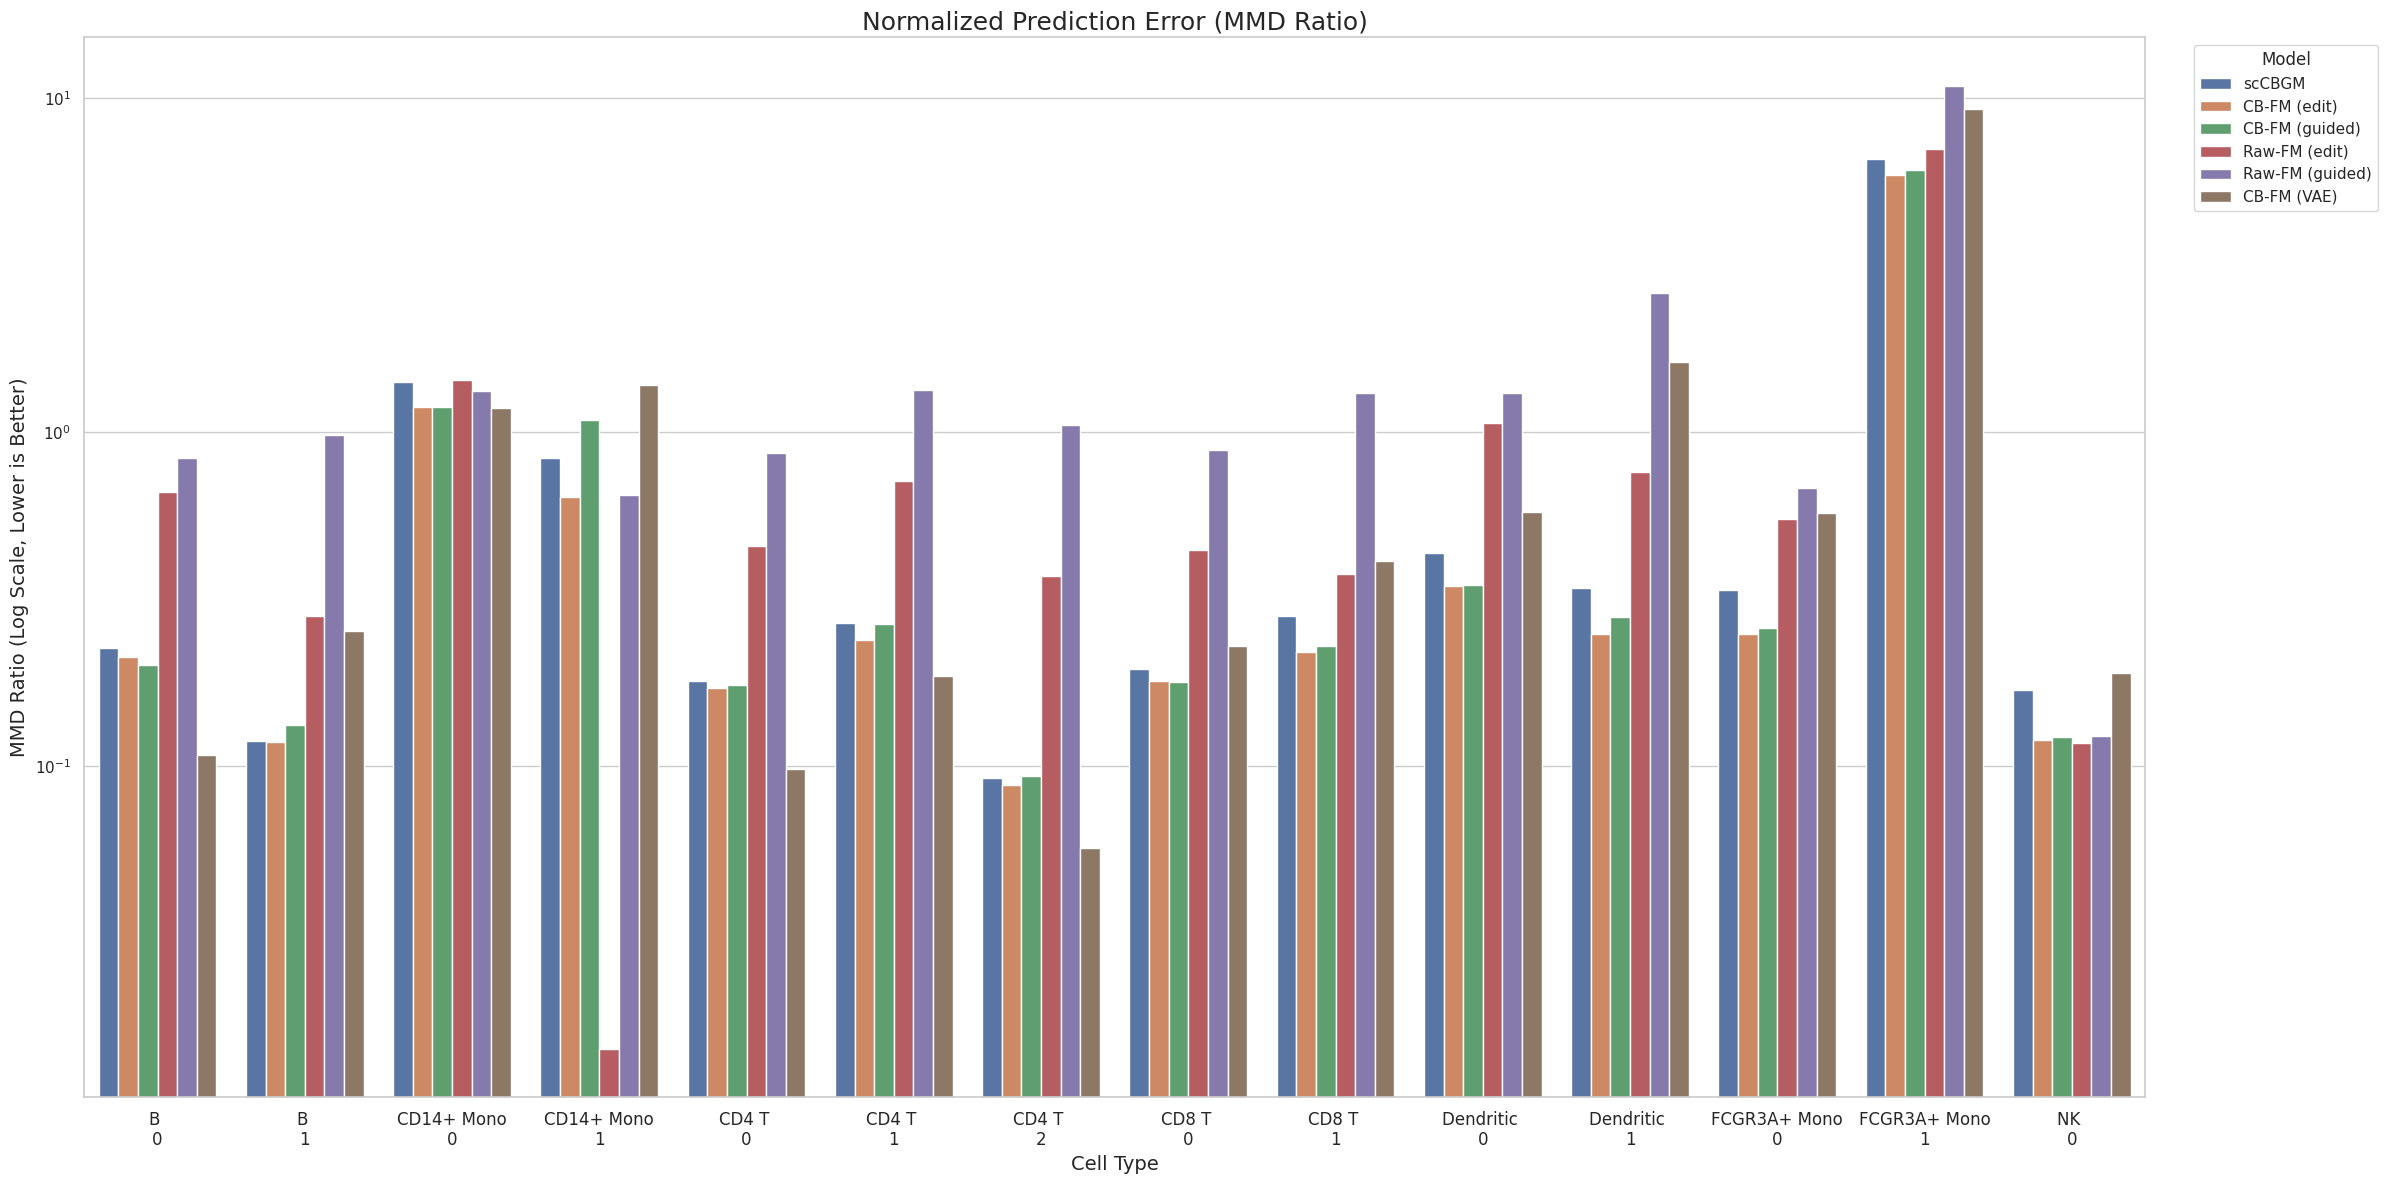

In [ ]:



# --- 2. Create Plots ---
fig, ax = plt.subplots(1, 1, figsize=(24, 12)) # Adjusted figsize for a single plot

sorted_labels = sorted(list(set(cell_labels)))

# --- Plot MMD Ratio, ensuring the x-axis is sorted ---
sns.barplot(data=df, x='label', y='mmd_ratio', hue='model', ax=ax, order=sorted_labels)

# --- SET Y-AXIS TO LOG SCALE ---
ax.set_yscale('log')

ax.set_ylabel('MMD Ratio (Log Scale, Lower is Better)', fontsize=14)
ax.set_xlabel('Cell Type', fontsize=14)
ax.set_title('Normalized Prediction Error (MMD Ratio)', fontsize=18)

# Format x-tick labels to be on two lines based on the sorted list
new_labels = [label.replace('_', '\n') for label in sorted_labels]
new_labels = [label.replace('Monocytes', 'Mono') for label in new_labels]
new_labels = [label.replace('cells', '') for label in new_labels]
ax.set_xticklabels(new_labels, fontsize=12)

ax.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')

# Adjust layout to make space for the external legend and the main title
plt.tight_layout()
plt.show()

# Run SWEEP

In [28]:
sweep_results = []

In [33]:
for sweep_label in ['CD8 T cells_1']:#, 'Dendritic cells_1']:#, 'CD4 T cells_0', 'CD8 T cells_0', 'Dendritic cells_0', 'FCGR3A+ Monocytes_0']:
    hold_out_label = sweep_label + '_stim'
    mod_label = sweep_label + '_ctrl'
    adata, adata_train, adata_test, adata_inter = split_data(
        adata, hold_out_label, mod_label, label_key = 'L2_stim'
    )
    

    adata.uns['pc_transform'] = sklearn.decomposition.PCA(n_components=128).fit(adata_train.X)
    for x_data in [adata_train, adata_test, adata_inter]: # Only transform necessary splits
        x_data.uns['pc_transform'] = adata.uns['pc_transform']
        x_data.obsm['X_pca'] = x_data.uns['pc_transform'].transform(x_data.X)

    # We need to calculate the baseline MMD for this specific data split
    baseline_eval = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
        x_train=adata_train.obsm[OBSM_KEY], x_ivn=adata_train.obsm[OBSM_KEY], x_target=adata_test.obsm[OBSM_KEY],
        labels_train=adata_train.obs['L1_stim'].values
    )
    pre_computed_mmd_train_sweep = baseline_eval['pre_computed_mmd_train']
    print(f"Baseline MMD for sweep set: {pre_computed_mmd_train_sweep:.4f}")
    
    # --- Define hyperparameter values and run sweep ---
    kl_hp_values = [1.0] #[0.1, 0.3, 0.5, 1.0]
    concepts_hp_values = [0.3]#[0.1, 0.3, 0.5, 1.0]
    orthogonality_hp_values = [0.1]#[0.1, 0.3, 0.5, 1.0]

    hp_combinations = list(itertools.product(kl_hp_values, concepts_hp_values, orthogonality_hp_values))
    print(f"Testing {len(hp_combinations)} hyperparameter combinations...")

    for i, (kl, concepts, ortho) in enumerate(hp_combinations):
        cb_fm_vae_model = train_cb_fm_vae(adata_train.copy(), kl_hp=kl, concepts_hp=concepts, orthogonality_hp=ortho)
        pred_adata_cb_fm_vae = pred_cb_fm_vae(cb_fm_vae_model, adata_inter.copy())
        
        evaluation = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
            x_train=adata_train.obsm[OBSM_KEY], x_ivn=pred_adata_cb_fm_vae.obsm[OBSM_KEY], x_target=adata_test.obsm[OBSM_KEY],
            labels_train=adata_train.obs['L1_stim'].values)#, pre_computed_mmd_train=pre_computed_mmd_train_sweep)
        mmd_ratio = evaluation['mmd_ratio']
        true_mmd = mmd_ratio * pre_computed_mmd_train_sweep
        
        sweep_results.append({
            'label': sweep_label, 'kl_hp': kl, 'concepts_hp': concepts, 'orthogonality_hp': ortho,
            'mmd_ratio': mmd_ratio, 'true_mmd': true_mmd
        })
        
        if (i + 1) % 25 == 0:
            print(f"  ... completed {i+1}/{len(hp_combinations)} runs")


Splitting data with simplified logic...
Baseline MMD for sweep set: 0.0651
Testing 1 hyperparameter combinations...
Training Concept Flow Model
Starting training on cuda for 200 epochs...


Training Progress: 100%|███████████████████████████████| 200/200 [04:29<00:00,  1.35s/it, avg_loss=2.899e-01, fm_loss=2.521e-01, concept_f1=9.989e-01]


Performing intervention with CB_FM_VAE...
Decoding with 1000 steps and cfg_strength 1.0


In [45]:
pred_adata_cb_fm_vae = pred_cb_fm_vae(cb_fm_vae_model, adata_inter.copy())

evaluation = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
    x_train=adata_train.obsm[OBSM_KEY], x_ivn=pred_adata_cb_fm_vae.obsm[OBSM_KEY], x_target=adata_test.obsm[OBSM_KEY],
    labels_train=adata_train.obs['L1_stim'].values)#, pre_computed_mmd_train=pre_computed_mmd_train_sweep)
mmd_ratio = evaluation['mmd_ratio']

print(mmd_ratio)
true_mmd = mmd_ratio * pre_computed_mmd_train_sweep

sweep_results.append({
    'label': sweep_label, 'kl_hp': kl, 'concepts_hp': concepts, 'orthogonality_hp': ortho,
    'mmd_ratio': mmd_ratio, 'true_mmd': true_mmd
})

# print(sweep_results)
# if (i + 1) % 25 == 0:
#     print(f"  ... completed {i+1}/{len(hp_combinations)} runs")

Performing intervention with CB_FM_VAE...
Decoding with 1000 steps and cfg_strength 1.0


0.23742641457833583


In [46]:
sweep_results[-1]

{'label': 'CD8 T cells_1',
 'kl_hp': 1.0,
 'concepts_hp': 0.3,
 'orthogonality_hp': 0.1,
 'mmd_ratio': np.float64(0.23742641457833583),
 'true_mmd': np.float64(0.015466240427172347)}

In [34]:
pre_computed_mmd_train_sweep

np.float64(0.06514119523996542)

In [39]:
evaluation

{'mmd_ratio': np.float64(0.247098031886181),
 'pre_computed_mmd_train': np.float64(0.06514119523996542)}

In [32]:
sweep_results_df = pd.DataFrame(sweep_results)

In [23]:
sweep_results_df

,label,kl_hp,concepts_hp,orthogonality_hp,mmd_ratio,true_mmd
0,CD8 T cells_1,1.0,0.3,0.1,0.255949,0.016626
1,Dendritic cells_1,1.0,0.3,0.1,0.306879,0.047549


In [161]:
sweep_results_df[sweep_results_df['label']=='CD8 T cells_1']#.iloc[48, :]

,label,kl_hp,concepts_hp,orthogonality_hp,mmd_ratio,true_mmd
0,CD8 T cells_1,0.1,0.1,0.1,0.327056,0.021365
1,CD8 T cells_1,0.1,0.1,0.3,0.665865,0.043498
2,CD8 T cells_1,0.1,0.1,0.5,0.669364,0.043727
3,CD8 T cells_1,0.1,0.1,1.0,0.546128,0.035676
4,CD8 T cells_1,0.1,0.3,0.1,0.435856,0.028473
...,...,...,...,...,...,...
59,CD8 T cells_1,1.0,0.5,1.0,0.466904,0.030501
60,CD8 T cells_1,1.0,1.0,0.1,0.331803,0.021675
61,CD8 T cells_1,1.0,1.0,0.3,0.284836,0.018607
62,CD8 T cells_1,1.0,1.0,0.5,0.349997,0.022864


In [169]:
sweep_results_df.loc[sweep_results_df[sweep_results_df['label']=='CD8 T cells_1']['mmd_ratio'].idxmin()]

label               CD8 T cells_1
kl_hp                         1.0
concepts_hp                   0.1
orthogonality_hp              0.1
mmd_ratio                0.224464
true_mmd                 0.014663
Name: 48, dtype: object

In [174]:
sweep_results_df.loc[sweep_results_df[sweep_results_df['label']=='Dendritic cells_1']['mmd_ratio'].idxmin()]

label               Dendritic cells_1
kl_hp                             1.0
concepts_hp                       0.3
orthogonality_hp                  0.1
mmd_ratio                    0.259403
true_mmd                     0.040378
Name: 116, dtype: object

In [173]:
for row in sweep_results_df.itertuples():
    print(f"Label: {row.label}, KL: {row.kl_hp}, Concepts: {row.concepts_hp}, Ortho: {row.orthogonality_hp}, MMD Ratio: {row.mmd_ratio:.4f}, True MMD: {row.true_mmd:.4f}")

Label: CD8 T cells_1, KL: 0.1, Concepts: 0.1, Ortho: 0.1, MMD Ratio: 0.3271, True MMD: 0.0214
Label: CD8 T cells_1, KL: 0.1, Concepts: 0.1, Ortho: 0.3, MMD Ratio: 0.6659, True MMD: 0.0435
Label: CD8 T cells_1, KL: 0.1, Concepts: 0.1, Ortho: 0.5, MMD Ratio: 0.6694, True MMD: 0.0437
Label: CD8 T cells_1, KL: 0.1, Concepts: 0.1, Ortho: 1.0, MMD Ratio: 0.5461, True MMD: 0.0357
Label: CD8 T cells_1, KL: 0.1, Concepts: 0.3, Ortho: 0.1, MMD Ratio: 0.4359, True MMD: 0.0285
Label: CD8 T cells_1, KL: 0.1, Concepts: 0.3, Ortho: 0.3, MMD Ratio: 0.4246, True MMD: 0.0277
Label: CD8 T cells_1, KL: 0.1, Concepts: 0.3, Ortho: 0.5, MMD Ratio: 0.5573, True MMD: 0.0364
Label: CD8 T cells_1, KL: 0.1, Concepts: 0.3, Ortho: 1.0, MMD Ratio: 0.4688, True MMD: 0.0306
Label: CD8 T cells_1, KL: 0.1, Concepts: 0.5, Ortho: 0.1, MMD Ratio: 0.3342, True MMD: 0.0218
Label: CD8 T cells_1, KL: 0.1, Concepts: 0.5, Ortho: 0.3, MMD Ratio: 0.5116, True MMD: 0.0334
Label: CD8 T cells_1, KL: 0.1, Concepts: 0.5, Ortho: 0.5, MM

In [170]:
df[df['label']=='Dendritic cells_1']#.iloc[48, :]

,label,model,true_mmd,mmd_ratio
3,Dendritic cells_1,scCBGM,0.053406,0.341126
17,Dendritic cells_1,CB-FM (edit),0.039029,0.249293
31,Dendritic cells_1,CB-FM (guided),0.043712,0.279203
45,Dendritic cells_1,Raw-FM (edit),0.118755,0.758535
59,Dendritic cells_1,Raw-FM (guided),0.408974,2.612267
73,Dendritic cells_1,CB-FM (VAE),0.253764,1.619770


In [ ]:
kl = 0.3, concepts_hp = 0.5, orthogonality_hp = 0.3